In [9]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
from matplotlib import pyplot as plt
from opf.plot import plot_equality, plot_inequality

%aimport opf
%aimport opf.modules
%aimport opf.constraints
%aimport opf.utils
%aimport opf.power

In [11]:
param = dict(
    case_name="case30",
    adj_scaling="auto",
    adj_threshold=0.01,
    batch_size=256,
    max_epochs=1000,
    K=8,
    F=256,
    gnn_layers=4,
    MLP=4,
    mlp_layers=1,
    s=10,
    t=500,
    cost_weight=0.1,
    lr=1e-4,
    constraint_features=True,
)

root_dir = "../"
data_dir = root_dir + "data/"
log_dir = root_dir + "logs/"

In [12]:
from pytorch_lightning.loggers import WandbLogger
from opf.utils import model_from_parameters

logger = WandbLogger(project="opf", save_dir=log_dir, config=param)
barrier, trainer, dm = model_from_parameters(
    param,
    gpus=1,
    logger=logger,
    data_dir=data_dir,
    patience=50
)
logger.watch(barrier)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GNN  | 2.5 M 
-------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
20.096    Total estimated model params size (MB)
/home/damow/.pyenv/versions/opf/lib/python3.9/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 90 steps due to diverging loss.
Restored states from the checkpoint file at /home/damow/repos/OPF/notebooks/lr_find_temp_model.ckpt
Learning rate set to 4.36515832240166e-06


4.36515832240166e-06

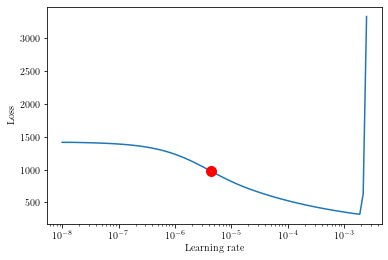

In [13]:
result = trainer.tune(barrier, datamodule=dm, lr_find_kwargs=dict(min_lr=1e-8, max_lr=1e-2))
lr_finder = result["lr_find"]
lr_finder.plot(suggest=True)
display(barrier.hparams.lr)

In [14]:
trainer.fit(barrier, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GNN  | 2.5 M 
-------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
20.096    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 89it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
trainer.test(datamodule=dm, ckpt_path="best")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acopf/cost': 1.4139745235443115,
 'acopf/equality/error_max': 0.0,
 'acopf/equality/error_mean': 0.0,
 'acopf/equality/loss': 8.909831983316963e-09,
 'acopf/equality/rate': 0.0,
 'acopf/inequality/error_max': 0.0,
 'acopf/inequality/error_mean': 0.0,
 'acopf/inequality/loss': 0.016814110800623894,
 'acopf/inequality/rate': 0.0,
 'test/cost': 1.3521101474761963,
 'test/equality/error_max': 0.0,
 'test/equality/error_mean': 0.0,
 'test/equality/loss': 1.6589408612013162e-13,
 'test/equality/rate': 0.0,
 'test/inequality/error_max': 0.03254477307200432,
 'test/inequality/error_mean': 0.009373554028570652,
 'test/inequality/loss': 0.03020951710641384,
 'test/inequality/rate': 0.002804266754537821}
--------------------------------------------------------------------------------


[{'test/cost': 1.3521101474761963,
  'test/equality/loss': 1.6589408612013162e-13,
  'test/equality/rate': 0.0,
  'test/equality/error_mean': 0.0,
  'test/equality/error_max': 0.0,
  'test/inequality/loss': 0.03020951710641384,
  'test/inequality/rate': 0.002804266754537821,
  'test/inequality/error_mean': 0.009373554028570652,
  'test/inequality/error_max': 0.03254477307200432,
  'acopf/cost': 1.4139745235443115,
  'acopf/equality/loss': 8.909831983316963e-09,
  'acopf/equality/rate': 0.0,
  'acopf/equality/error_mean': 0.0,
  'acopf/equality/error_max': 0.0,
  'acopf/inequality/loss': 0.016814110800623894,
  'acopf/inequality/rate': 0.0,
  'acopf/inequality/error_mean': 0.0,
  'acopf/inequality/error_max': 0.0}]

In [16]:
import wandb
logger.finalize("finished")
wandb.finish()

train/loss,0.22073
train/cost,1.0553
train/equality/loss,0.3223
train/equality/rate,0.99948
train/equality/error_mean,0.03752
train/equality/error_max,0.15364
train/inequality/loss,0.4841
train/inequality/rate,0.16682
train/inequality/error_mean,0.01844
train/inequality/error_max,0.31168
epoch,205


train/loss,▇█▃▁▁▁▁▁▁▁▁▂▁▃▂▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▃▁▁▁▁▁▁▁▁
train/cost,▁▃▆▇████████████████████████████████████
train/equality/loss,▁█▃▁▁▁▁▁▁▁▁▂▁▃▂▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▃▁▁▁▁▁▁▁▁
train/equality/rate,█████▅▆▇█▇▅▆███▇██▆██▆▆█▁▄▅██▇▅█▄█▄██▆▇▇
train/equality/error_mean,██▄▂▂▁▁▂▂▂▁▃▁▃▃▂▃▂▁▂▃▂▂▁▁▁▁▃▂▁▂▃▁▂▁▁▂▁▁▂
train/equality/error_max,▅█▄▂▂▁▁▂▂▂▁▂▁▃▃▂▃▁▁▂▂▂▂▁▁▁▁▂▂▂▁▃▁▁▁▁▂▁▂▂
train/inequality/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/inequality/rate,██▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁
train/inequality/error_mean,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/inequality/error_max,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
